# Hydration Analysis

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,8]

Importing the file containing the PBAs with water molecules:

In [2]:
# with open('pba_w_APR.json', 'r') as file :
#   pba_json = file.read()

In [3]:
# print(pba_json[:1000])

In [4]:
from monty.serialization import loadfn

In [5]:
data_1 = loadfn('pba_w_APR.json')

In [164]:
# data_1[0]

In [7]:
import pymatgen as mg
from pymatgen.entries.computed_entries import ComputedEntry

In [8]:
pba_entries = []
for i in range((len(data_1))):
    #Creating pymatgen entry:
    entry = ComputedEntry(composition=data_1[i]['input']['structure'].composition,
                              energy=data_1[i]['output']['energy'],
                              parameters = {"nelect": data_1[i]['input']['parameters']['NELECT'],
                                            "hubbards": data_1[i]['input']['hubbards'],
                                            "potcar_spec": data_1[i]['input']['potcar_spec'],
                                            "is_hubbard": data_1[i]['input']['is_hubbard']})
    
#     if 'H' in entry.composition or 'O' in entry.composition: #Filtering out structures with hydrogen or oxygen
#         pba_entries.append('')
    if entry.composition.as_dict()['C'] != 24 or entry.composition.as_dict()['N'] != 24:
        #Filtering out structures that don't have 24 Cs or 24 Ns - these are also not PBAs
        pba_entries.append('')
    else:
        pba_entries.append(entry)

In [165]:
pba_entries[0]

ComputedEntry None - Ca4 Fe4 Co4 C24 N24
Energy = -476.8671
Correction = 0.0000
Parameters:
nelect = 348.0
hubbards = {}
potcar_spec = [{'titel': 'PAW_PBE Ca_sv 06Sep2000', 'hash': 'eb006721e214c04b3c13146e81b3a27d'}, {'titel': 'PAW_PBE Fe_pv 06Sep2000', 'hash': '5963411539032ec3298fa675a32c5e64'}, {'titel': 'PAW_PBE Co 06Sep2000', 'hash': 'b169bca4e137294d2ab3df8cbdd09083'}, {'titel': 'PAW_PBE C 08Apr2002', 'hash': 'c0a8167dbb174fe492a3db7f5006c0f8'}, {'titel': 'PAW_PBE N 08Apr2002', 'hash': 'b98fd027ddebc67da4063ff2cabbc04b'}]
is_hubbard = False
Data:

In [10]:
len(pba_entries)

3783

In [166]:
pba_h2o = []
for i in range(len(pba_entries)):
    if pba_entries[i] == '':
        continue
    if 'O' in pba_entries[i].composition.as_dict().keys():
        pba_h2o.append(pba_entries[i])
#         print(i)
pba_h2o[0]

ComputedEntry None - Mn4 Fe4 H2 C24 N24 O1
Energy = -492.5684
Correction = 0.0000
Parameters:
nelect = 332.0
hubbards = {}
potcar_spec = [{'titel': 'PAW_PBE Mn_pv 07Sep2000', 'hash': 'fa52f891f234d49bb4cb5ea96aae8f98'}, {'titel': 'PAW_PBE Fe_pv 06Sep2000', 'hash': '5963411539032ec3298fa675a32c5e64'}, {'titel': 'PAW_PBE H 15Jun2001', 'hash': 'bb43c666e3d36577264afe07669e9582'}, {'titel': 'PAW_PBE C 08Apr2002', 'hash': 'c0a8167dbb174fe492a3db7f5006c0f8'}, {'titel': 'PAW_PBE N 08Apr2002', 'hash': 'b98fd027ddebc67da4063ff2cabbc04b'}, {'titel': 'PAW_PBE O 08Apr2002', 'hash': '7a25bc5b9a5393f46600a4939d357982'}]
is_hubbard = False
Data:

In [12]:
len(pba_h2o)

329

From this, we see that there are 329 PBAs with water molecules.

Because we previously found that the relationship between # water molecules and (Total PBA energy - energy of water molecules). 

In [13]:
from pymatgen import MPRester
mpr = MPRester(api_key='clRGHmBDgp1xt9zA')
from pymatgen.entries.compatibility import MaterialsProjectCompatibility
mpc = MaterialsProjectCompatibility()
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter
import pymatgen.analysis.local_env as localenv
crys = localenv.CrystalNN()

In [14]:
def my_crystal_nn(struct):
    '''
    Returns the A, P, and R atoms of a PBA in a list [A,P,R].
    struct is data in the form data_1[i]['input']['structure'] and must be a PBA.
    Uses pymatgen's CrystalNN method.
    '''
    A_atom_nn,P_atom_nn, R_atom_nn = '','','' #Initializing A, P, and R atoms
    for j in range(len(struct)): #Looping through all of the elements in the PBA
        atom = struct[j].as_dict()['species'][0]['element']
        
        if atom == 'C' and len(R_atom_nn)==0:
            nn_objs = crys.get_nn_info(struct, j) #getting the nearest neighbors for atom, which is the jth atom in struct
            for k in range(len(nn_objs)):
                nn = nn_objs[k]['site'].as_dict()['species'][0]['element']
                if nn != 'N':
                    R_atom_nn = nn
                    break
                    
        elif atom == 'N' and len(P_atom_nn)==0:
            nn_objs = crys.get_nn_info(struct, j) #getting the nearest neighbors for atom, which is the jth atom in struct
            for k in range(len(nn_objs)):
                nn = nn_objs[k]['site'].as_dict()['species'][0]['element']
                if nn != 'C':
                    P_atom_nn = nn
                    break
                    
    for j in struct.composition.as_dict().keys():
        if j not in [P_atom_nn,R_atom_nn,'C','N','H','O']:
            A_atom_nn = j
            break
    return [A_atom_nn,P_atom_nn,R_atom_nn]

### Main Loop
Here, we extract the e_hull, A/P/R atoms, # A atoms, and # water molecules for each PBA into a dataframe.

In [15]:
# pba_e_hull_df = pd.DataFrame(index=range(len(data_1)),columns=['Composition','Formula','e_above_hull','A_atom','P_atom','R_atom','n_A','n_H2O'])
# for i in range(len(pba_entries)):
#     try:
#         if i%250 == 0:
#             print(str(i) + 'th iteration') #Just to make it easier to keep track of how the algorithm is running
            
#         struct=data_1[i]['input']['structure']
#         pba_entry = pba_entries[i]
#         if type(pba_entry) == str: #If the entry is string, then it was filtered out and we didn't create a pymatgen entry for it.
#             continue
#         comp = pba_entry.composition

#         h2o_flag = False #Setting up a flag to tell whether this PBA is hydrated
#         if 'O' in comp.as_dict().keys():
#             h2o_flag = True

#         comp_dict = {'structure': my_crystal_nn(struct)} #Using my custom CrystalNN function to get the A,P,R

#         repeat_flag = False #initializing flag to indicate whether to move on to next structure because this is a repeat
#         for prev in range(i): #loop through previously created entriaes to check if there are for the exact same PBA:
#             if ((comp_dict['structure'][0] == pba_e_hull_df.iloc[prev,3]) & #Checks if A atom is same
#                 (comp_dict['structure'][1] == pba_e_hull_df.iloc[prev,4]) & #Checks P atom
#                 (comp_dict['structure'][2] == pba_e_hull_df.iloc[prev,5]) & #Checks R atom
#                 (comp.as_dict()[comp_dict['structure'][0]] == pba_e_hull_df.iloc[prev,6]) & #Checks # of A atoms
#                 (comp.as_dict()['O'] == pba_e_hull_df.iloc[prev,7])): #checks # water molecules
#                 repeat_flag = True
#                 break
#         if repeat_flag:
#             continue

#         #Making list of other PBAs from list pba_entries with the same composition:
#         same_comps = []
#         for j in range(len(pba_entries)):
#             if type(pba_entries[j]) is str: #skip empty entries
#                 continue
#             if pba_entries[j].composition == comp:
#                 same_comps.append([pba_entries[j],j])

#         for k in range(len(same_comps)):
#             comp_dict[same_comps[k][1]] = my_crystal_nn(data_1[same_comps[k][1]]['input']['structure'])
#         #comp_dict is now a dictionary of all structures in data_1 with the same composition. The dictionary index
#         #is the index of the structure in data_1, and the value is a list of the [A,P,R] atom identities.

#         for k in range(len(same_comps)):
#             if comp_dict[same_comps[k][1]][1] != comp_dict['structure'][1] or comp_dict[same_comps[k][1]][2] != comp_dict['structure'][2]:
#                 del comp_dict[same_comps[k][1]]
#         #comp_dict is now a dictionary of the structures in data_1 with same composition AND same A,P,R atoms

#         #We also want to delete the structures with different APR atoms dictionary from the same_comp list.
#         same_comps_and_APR = []
#         for k in range(len(same_comps)):
#             if same_comps[k][1] in comp_dict.keys(): #check if the index for that structure is in the comp_dict keys
#                 same_comps_and_APR.append(same_comps[k][0])
#         #same_comps_and_APR is now a list of the pymatgen entries with the same composition and APR atoms

#         #Accessing MP data for structures with the any of the same atoms:
#         comp_atoms = comp.as_dict().keys()
#         entries = mpr.get_entries_in_chemsys(comp_atoms)
#         #Adding our pbas to this list of pymatgen entries:
#         entries = entries + same_comps_and_APR

#         #Applying correction using MPRester:
#         corrected_entries = mpc.process_entries(entries)

#         #If PBA is hydrated (conatains at least one H2O), the corrected_entries step will get rid of the PBAs.
#         #Therefore, we add the pba entries back into the corrected_entries list here:
#         if h2o_flag:
#             corrected_entries = corrected_entries + same_comps_and_APR

#         #Making phase diagram:
#         phase_d = PhaseDiagram(corrected_entries)

#         #Looping through the PBA structures to find the lowest energy above hull value:
#         e_above_hull_list = []
#         for k in range(1,len(same_comps_and_APR)+1):
#             e_above_hull_list.append(phase_d.get_e_above_hull(corrected_entries[-k]))
#         e_above_hull = min(e_above_hull_list)

#         #Adding the values known so far to the main df:
#         pba_e_hull_df.loc[i, 'Composition'] = comp
#         pba_e_hull_df.loc[i, 'Formula'] = comp.formula
#         pba_e_hull_df.loc[i, 'e_above_hull'] = e_above_hull

#         #Adding the A, P, and R atoms to main df:
#         pba_e_hull_df.loc[i, 'A_atom'] = comp_dict['structure'][0]
#         pba_e_hull_df.loc[i, 'P_atom'] = comp_dict['structure'][1]
#         pba_e_hull_df.loc[i, 'R_atom'] = comp_dict['structure'][2]
#         pba_e_hull_df.loc[i, 'n_A'] = comp.as_dict()[comp_dict['structure'][0]]
#         if h2o_flag:
#             pba_e_hull_df.loc[i, 'n_H2O'] = comp.as_dict()['O']
#         else:
#             pba_e_hull_df.loc[i, 'n_H2O'] = 0
        
#     except:
#         print('Error on ' + str(i))
#         continue

In [16]:
# pba_e_hull_df.head()

In [17]:
# #Saving to file as pba_e_hull_df_h2o.csv
# pba_e_hull_df.to_csv('pba_e_hull_df_h2o.csv')

In [18]:
pba_e_hull_df= pd.read_csv('pba_e_hull_df_h2o.csv')
pba_e_hull_df.drop('Unnamed: 0', axis = 1, inplace = True)

In [19]:
pba_e_hull_df.iloc[1287:1295]

,Composition,Formula,e_above_hull,A_atom,P_atom,R_atom,n_A,n_H2O
1287,Mn4 Fe4 H6 C24 N24 O3,Mn4 Fe4 H6 C24 N24 O3,0.253329,NaN,Mn,Fe,0.0,3.0
1288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1291,Rb8 V4 Fe4 C24 N24,Rb8 V4 Fe4 C24 N24,0.080950,Rb,V,Fe,8.0,0.0
1292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1294,Rb8 Mn4 Zn4 C24 N24,Rb8 Mn4 Zn4 C24 N24,0.128766,Rb,Zn,Mn,8.0,0.0


In [20]:
len(pba_e_hull_df[pba_e_hull_df['n_H2O'] > 0])

172

From this, we see that there are 172 unique structures that contain water molecules.

## Analyzing hydration data
We will use the e_hull values for the given structures to extrapolate the e_hull values for each PBA at 100% hydration. Using this, we will be able to determine what fraction of the PBAs are stable at 100% hydration.

Note that others have found in previous analyses that e_hull values have a very strong linear relationship with # of water molecules, so extrapolating e_hull values at 100% hydration is a safe method of determining stability.

In [170]:
pba_h2o = pba_e_hull_df[(pba_e_hull_df['n_H2O'] > 0)]

In [171]:
p_atoms = pba_h2o['P_atom'].unique()
p_atoms

array(['Mn', 'Fe', 'Cr', 'Co', 'Zn', 'V'], dtype=object)

In [172]:
r_atoms = pba_h2o['R_atom'].unique()
r_atoms

array(['Fe', 'Mn', 'Cr', 'Os', 'Co', 'V'], dtype=object)

### Walking through the analysis for one PBA:

In [173]:
mn_fe = pba_h2o[(pba_h2o['P_atom'] == 'Mn') & (pba_h2o['R_atom'] == 'Fe')]
mn_fe = mn_fe.sort_values(by = 'n_H2O')
mn_fe

,Composition,Formula,e_above_hull,A_atom,P_atom,R_atom,n_A,n_H2O
1255,Mn4 Fe4 H2 C24 N24 O1,Mn4 Fe4 H2 C24 N24 O1,0.214177,NaN,Mn,Fe,0.0,1.0
1881,Mn4 Fe4 H4 C24 N24 O2,Mn4 Fe4 H4 C24 N24 O2,0.234781,NaN,Mn,Fe,0.0,2.0
1287,Mn4 Fe4 H6 C24 N24 O3,Mn4 Fe4 H6 C24 N24 O3,0.253329,NaN,Mn,Fe,0.0,3.0
1261,Mn4 Fe4 H8 C24 N24 O4,Mn4 Fe4 H8 C24 N24 O4,0.269570,NaN,Mn,Fe,0.0,4.0
1903,Mn4 Fe4 H10 C24 N24 O5,Mn4 Fe4 H10 C24 N24 O5,0.285426,NaN,Mn,Fe,0.0,5.0
1891,Mn4 Fe4 H12 C24 N24 O6,Mn4 Fe4 H12 C24 N24 O6,0.299790,NaN,Mn,Fe,0.0,6.0
1901,Mn4 Fe4 H14 C24 N24 O7,Mn4 Fe4 H14 C24 N24 O7,0.312793,NaN,Mn,Fe,0.0,7.0
1913,Mn4 Fe4 H16 C24 N24 O8,Mn4 Fe4 H16 C24 N24 O8,0.325585,NaN,Mn,Fe,0.0,8.0


This PBA already has entries for all 8 hydration levels. Let's take a look at a simple plot of e_hull vs n_H2O:

Text(0,0.5,'e_above_hull')

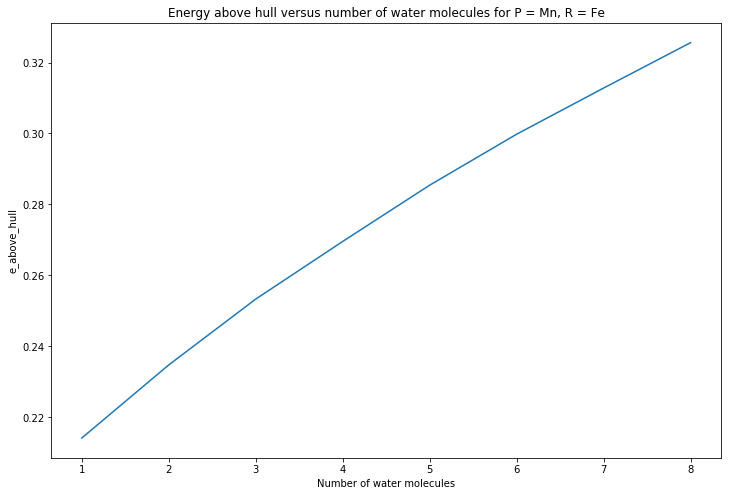

In [174]:
plt.plot(mn_fe['n_H2O'],mn_fe['e_above_hull'])
plt.title('Energy above hull versus number of water molecules for P = Mn, R = Fe')
plt.xlabel('Number of water molecules')
plt.ylabel('e_above_hull')

Because the e_hull value for this PBA is greater than 0.25 at 100% hydration, we would consider this PBA unstable.

Let's take a look at another PBA:

In [175]:
p5  = p_atoms[5]
p5

'V'

In [176]:
r5 = r_atoms[5]
r5

'V'

In [177]:
cr_v = pba_h2o[(pba_h2o['P_atom'] == 'Cr') & (pba_h2o['R_atom'] == 'V')]
cr_v = cr_v.sort_values(by = 'n_H2O')
cr_v

,Composition,Formula,e_above_hull,A_atom,P_atom,R_atom,n_A,n_H2O
2099,V4 Cr4 H2 C24 N24 O1,V4 Cr4 H2 C24 N24 O1,0.383514,NaN,Cr,V,0.0,1.0
2076,V4 Cr4 H6 C24 N24 O3,V4 Cr4 H6 C24 N24 O3,0.393075,NaN,Cr,V,0.0,3.0
1950,V4 Cr4 H8 C24 N24 O4,V4 Cr4 H8 C24 N24 O4,0.400650,NaN,Cr,V,0.0,4.0
2108,V4 Cr4 H12 C24 N24 O6,V4 Cr4 H12 C24 N24 O6,0.420777,NaN,Cr,V,0.0,6.0
2063,V4 Cr4 H16 C24 N24 O8,V4 Cr4 H16 C24 N24 O8,0.431159,NaN,Cr,V,0.0,8.0


In [178]:
7 in cr_v['n_H2O'].values

False

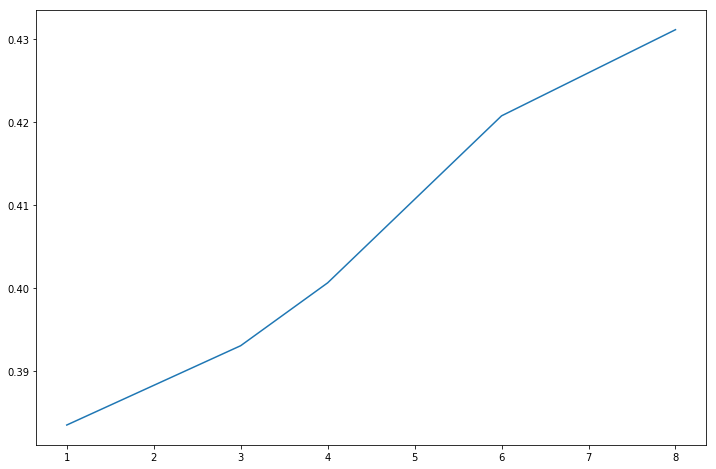

In [179]:
plt.plot(cr_v['n_H2O'],cr_v['e_above_hull'])

Both of these PBAs already have an entry for the 100% hydrated structure. Let's check if there are any PBAs that don't have the 100% hydrated strucutre, which means we would have to extraplolate those e_hulls.

In [180]:
for p in p_atoms:
    for r in r_atoms:
        pbas = pba_h2o[(pba_h2o['P_atom'] == p) & (pba_h2o['R_atom'] == r)]
        if 8 in pbas['n_H2O'].values:
            continue
        else:
            print(p, r)

Mn Mn
Mn Cr
Mn Co
Fe Co
Cr Os
Co Fe
Co Mn
Co Cr
Co V
Zn Fe
Zn Os
Zn Co
Zn V
V Co


Okay, so we'll have to extrapolate the e_hull for the 100% hydrated structure for these PBAs. Let's walk through the process for the Mn Mn PBA:

In [72]:
mn_mn = pba_h2o[(pba_h2o['P_atom'] == 'Mn') & (pba_h2o['R_atom'] == 'Mn')]
mn_mn = mn_mn.sort_values(by = 'n_H2O')
mn_mn

,Composition,Formula,e_above_hull,A_atom,P_atom,R_atom,n_A,n_H2O
2161,Mn8 H2 C24 N24 O1,Mn8 H2 C24 N24 O1,0.256120,NaN,Mn,Mn,0.0,1.0
2212,Mn8 H4 C24 N24 O2,Mn8 H4 C24 N24 O2,0.274493,NaN,Mn,Mn,0.0,2.0
2159,Mn8 H6 C24 N24 O3,Mn8 H6 C24 N24 O3,0.291061,NaN,Mn,Mn,0.0,3.0
1877,Mn8 H8 C24 N24 O4,Mn8 H8 C24 N24 O4,0.305722,NaN,Mn,Mn,0.0,4.0
2144,Mn8 H10 C24 N24 O5,Mn8 H10 C24 N24 O5,0.319600,NaN,Mn,Mn,0.0,5.0
2165,Mn8 H12 C24 N24 O6,Mn8 H12 C24 N24 O6,0.332498,NaN,Mn,Mn,0.0,6.0
2233,Mn8 H14 C24 N24 O7,Mn8 H14 C24 N24 O7,0.344063,NaN,Mn,Mn,0.0,7.0


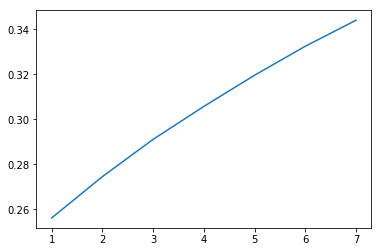

In [73]:
plt.plot(mn_mn['n_H2O'],mn_mn['e_above_hull'])

Let's try to use a simple linear regression model with scikit-learn to predict the e_hull at n_H2O = 8:

In [74]:
from sklearn import datasets, linear_model

In [75]:
regr = linear_model.LinearRegression()

In [82]:
x_data = mn_mn[['n_H2O']]
y_data = mn_mn[['e_above_hull']]

In [83]:
regr.fit(x_data, y_data)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [126]:
regr.predict(8)[0][0]

0.3617047019458272

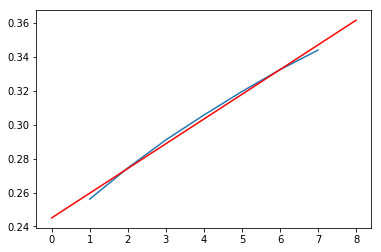

In [95]:
plt.plot(mn_mn['n_H2O'],mn_mn['e_above_hull'])
x_range = pd.DataFrame(data = {'x':range(0,9)})
plt.plot(x_range, regr.predict(x_range), color = 'r')

Here, the blue is the actual data and the red is the linear regression model. As we can see, the regression model matches the data very well. Let's see what the predicted e_hull value is for the fully hydrated Mn Mn PBA:

In [99]:
print(regr.predict(8))

[[0.3617047]]


Now that we know how to find the predicted e_hull for these PBAs we can write the full loop to get the e_hull values of all the PBAs. If the fully hydrated (n_H2O = 8) structure is provided, we will use the provided value. Otherwise, we will use linear regression to calculate the e_hull of the fully hydrated PBA.

In [181]:
e_hull_list_h2o = []
for p in p_atoms:
    for r in r_atoms:
        pbas = pba_h2o[(pba_h2o['P_atom'] == p) & (pba_h2o['R_atom'] == r)]
        if 8 in pbas['n_H2O'].values: #if fully hydrated PBA is already available:
            e_hull_list_h2o.append(pbas[pbas['n_H2O'] == 8]['e_above_hull'].values[0])
        else: #if fully hydrated PBA not available - have to do regression:
            n_h2o = pbas[['n_H2O']]
            e_above_hull = pbas[['e_above_hull']]
            if len(n_h2o) == 0: #i.e. there are no structures for PBA with these P and R atoms
                print('No hydrated structures provided for PBA with P = ' + str(p) + ' and R = ' + str(r))
            elif len(n_h2o) == 1: #Finding structures with only a single hydrated structure i.e. can't do regression
                print('Only one hydrated structure for PBA with P = ' + str(p) + ' and R = ' + str(r))
            else:
                regr.fit(n_h2o,e_above_hull)
                e_hull_list_h2o.append(regr.predict(8)[0][0])

No hydrated structures provided for PBA with P = Mn and R = Co
No hydrated structures provided for PBA with P = Fe and R = Co
No hydrated structures provided for PBA with P = Cr and R = Os
Only one hydrated structure for PBA with P = Co and R = Fe
Only one hydrated structure for PBA with P = Co and R = Mn
Only one hydrated structure for PBA with P = Co and R = Cr
No hydrated structures provided for PBA with P = Co and R = V
No hydrated structures provided for PBA with P = Zn and R = Fe
Only one hydrated structure for PBA with P = Zn and R = Os
No hydrated structures provided for PBA with P = Zn and R = Co
No hydrated structures provided for PBA with P = Zn and R = V
No hydrated structures provided for PBA with P = V and R = Co


In [184]:
len(e_hull_list_h2o)

24

There are 24 entries in the e_hull list, 8 PBAs with no hydrated structures, and 4 PBAs with only 1 hydrated structure, making a total of 36 PBAs. This makes sense because there are 6 unique P atoms and 6 unique R atoms, which multiply together for 36 total combinations.

Now that we have the requisite data, how many of the PBAs are stable at 100% hydration (n_H2O == 8)?

In [185]:
[i for i in e_hull_list_h2o if i < .25]

[]

As we can see there are no PBAs with e_hull values that fall below the 0.25 eV threshold for stability. When we take a look at all of the data, we see that several PBAs come close with e_hulls of around 0.27, but no are below the 0.25 eV threshold. 

Therefore, we can conclude that none of the given PBAs are stable at 100% hydration. Note that not all of the possible PBAs were analyzed because there were no hydrated structures for every PBA in the original data file.

In [186]:
e_hull_list_h2o

[0.3255846119050005,
 0.3617047019458272,
 0.40093056685898676,
 0.2660391129110007,
 0.4434286986549996,
 0.3703147903552209,
 0.3807030292799993,
 0.4092103159852494,
 0.3099355022362218,
 0.4716855383552217,
 0.3167506031102496,
 0.34637023780975,
 0.3559652892302223,
 0.2779513331052215,
 0.4311592951052212,
 0.3258758288612213,
 0.33539556548022104,
 0.4537688465864989,
 0.5105620944117213,
 0.33826284348022195,
 0.3637532829049999,
 0.39332460623022136,
 0.27398634286122103,
 0.4732573313552218]